['CT000000', 'CT000001', 'CT000002', 'CT000003', 'CT000004', 'CT000005', 'CT000006', 'CT000007', 'CT000008', 'CT000009', 'CT000010', 'CT000011', 'CT000012', 'CT000013', 'CT000014', 'CT000015', 'CT000016', 'CT000017', 'CT000018', 'CT000019', 'CT000020', 'CT000021', 'CT000022', 'CT000023', 'CT000024', 'CT000025', 'CT000026', 'CT000027', 'CT000028', 'CT000029', 'CT000030', 'CT000031', 'CT000032', 'CT000033', 'CT000034', 'CT000035', 'CT000036', 'CT000037', 'CT000038', 'CT000039', 'CT000040', 'CT000041', 'CT000042', 'CT000043', 'CT000044', 'CT000045', 'CT000046', 'CT000047', 'CT000048', 'CT000049', 'CT000050', 'CT000051', 'CT000052', 'CT000053', 'CT000054', 'CT000055', 'CT000056', 'CT000057', 'CT000058', 'CT000059', 'CT000060', 'CT000061', 'CT000062', 'CT000063', 'CT000064', 'CT000065', 'CT000066', 'CT000067', 'CT000068', 'CT000069', 'CT000070', 'CT000071', 'CT000072', 'CT000073', 'CT000074', 'CT000075', 'CT000076', 'CT000077', 'CT000078', 'CT000079', 'CT000080', 'CT000081', 'CT000082', 'CT

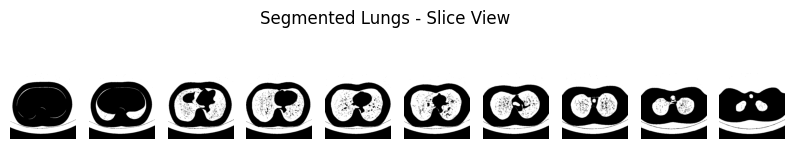

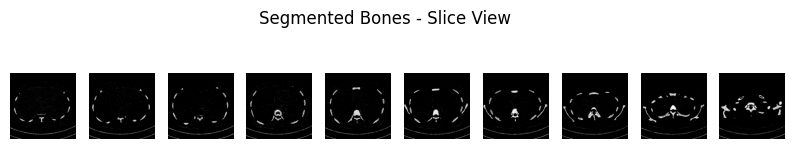

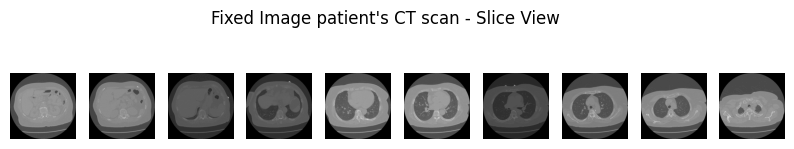

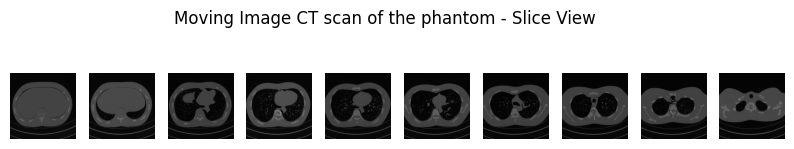

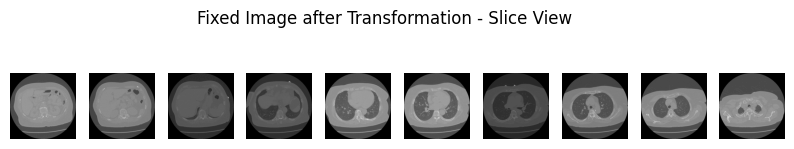

C:\Users\HP\AppData\Local\Temp\ipykernel_19692\772692046.py:82: RuntimeWarning: divide by zero encountered in divide
  image_array = ((image_array - image_array.min()) * (1/(image_array.max() - image_array.min()) * 255)).astype('uint8')
C:\Users\HP\AppData\Local\Temp\ipykernel_19692\772692046.py:82: RuntimeWarning: invalid value encountered in multiply
  image_array = ((image_array - image_array.min()) * (1/(image_array.max() - image_array.min()) * 255)).astype('uint8')


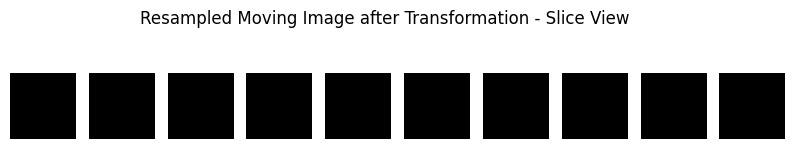

AttributeError: 'Transform' object has no attribute 'AddTransform'

In [1]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ipyvolume as ipv
import SimpleITK as sitk
import ipywidgets as widgets

# Loading the Data
data_path = r"C:\Users\HP\Documents\GitHub\3D-3D_Image_Registration\SE000003"

# List all files in the directory
files = os.listdir(data_path)
print(files)

def segment_lung(image):
    # Apply a threshold to separate lung pixels from others
    thresh_filter = sitk.ThresholdImageFilter()
    thresh_filter.SetLower(-1000)
    thresh_filter.SetUpper(-400)
    thresh_img = thresh_filter.Execute(image)
    
    # Apply morphological opening
    morph_filter = sitk.BinaryMorphologicalOpeningImageFilter()
    morph_img = morph_filter.Execute(thresh_img)
    
    # Apply Connected Component Labeling
    cc_filter = sitk.ConnectedComponentImageFilter()
    cc_img = cc_filter.Execute(morph_img)
    
    # Get the two largest components (assumed to be the lungs)
    relabel_filter = sitk.RelabelComponentImageFilter()
    relabel_img = relabel_filter.Execute(cc_img)
    
    # Get labels array
    labels_array = sitk.GetArrayFromImage(relabel_img)
    
    # Count the number of pixels in each region and sort by size
    unique, counts = np.unique(labels_array, return_counts=True)
    sorted_counts = sorted(zip(counts, unique), reverse=True)
    
    # Keep the two largest components (excluding background)
    lung_mask = np.isin(labels_array, [label for _, label in sorted_counts[1:3]])
    
    # Convert to SimpleITK image for further processing
    lung_mask_sitk = sitk.GetImageFromArray(lung_mask.astype(np.uint8))
    lung_mask_sitk.CopyInformation(image)
    
    return lung_mask_sitk  

def segment_bones(image):
    # Convert the SimpleITK image to a numpy array
    image_array = sitk.GetArrayFromImage(image)
    
    # Use thresholding to identify the bones
    # Bones have higher HU than soft tissues or air
    # This range might need adjustment depending on the specific scan
    bone_threshold = 300
    bone_mask = image_array > bone_threshold
    
    # Convert to SimpleITK image for further processing
    bone_mask_sitk = sitk.GetImageFromArray(bone_mask.astype(np.uint8))
    bone_mask_sitk.CopyInformation(image)
    
    return bone_mask_sitk


def load_dicom_series(directory_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(directory_path)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    return image

def display_images(image, title, montage_slices=10):
    # Convert the SimpleITK image to a numpy array
    image_array = sitk.GetArrayFromImage(image)
    
    # Normalize to 0-255
    image_array = ((image_array - image_array.min()) * (1/(image_array.max() - image_array.min()) * 255)).astype('uint8')
    
    # 3D visualization using ipyvolume
    ipv.figure()
    ipv.volshow(image_array, level=[0.25, 0.75], opacity=0.03, level_width=0.1, data_min=0, data_max=255)
    fig3d = ipv.gcc()
    
    # Create a layout with a title
    title_widget = widgets.HTML(f'<h2>{title} - 3D View</h2>')
    layout = widgets.VBox([title_widget, fig3d])
    display(layout)

    # Montage of slices using matplotlib
    fig = plt.figure(figsize=(10, 2))
    fig.suptitle(title + " - Slice View")
    slice_interval = image_array.shape[0] // montage_slices
    for i in range(montage_slices):
        ax = fig.add_subplot(1, montage_slices, i + 1)
        ax.imshow(image_array[i * slice_interval], cmap='gray')
        plt.axis('off')
    plt.show()


# Load the DICOM images
ct_image = load_dicom_series(data_path)

# Perform lung segmentation
lung_mask = segment_lung(ct_image)

# Convert the SimpleITK image to a numpy array for visualization
lung_mask_array = sitk.GetArrayFromImage(lung_mask)

# Display segmented lungs in 3D
display_images(lung_mask, "Segmented Lungs")



# Perform bone segmentation
bone_mask = segment_bones(ct_image)

## Display the bone segmentation in 3D and slices
display_images(bone_mask, "Segmented Bones")

# Paths to the DICOM directories
fixed_image_path = r"C:\Users\HP\Documents\GitHub\3D-3D_Image_Registration\manifest-1690161037914\COVID-19-NY-SBU\A042359\12-25-1900-NA-CT CHEST WO IV CONT-15429\4.000000-Lung 1.0-09229"
moving_image_path = r"C:\Users\HP\Documents\GitHub\3D-3D_Image_Registration\SE000003"


# Load the DICOM images
fixed_image = load_dicom_series(fixed_image_path)
moving_image = load_dicom_series(moving_image_path)

# Display the images with appropriate titles
display_images(fixed_image, "Fixed Image patient's CT scan")
display_images(moving_image, "Moving Image CT scan of the phantom")

# Apply the transformation
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMeanSquares()
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetInterpolator(sitk.sitkLinear)

initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

registration_method.SetInitialTransform(initial_transform, inPlace=False)
final_transform_v1 = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                 sitk.Cast(moving_image, sitk.sitkFloat32))

# Resample the moving image onto the fixed image's grid
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed_image)
resampler.SetTransform(final_transform_v1)
resampled_moving_image = resampler.Execute(moving_image)

# Display the images after transformation
display_images(fixed_image, "Fixed Image after Transformation")
display_images(resampled_moving_image, "Resampled Moving Image after Transformation")


# Apply the affine transformation
affine_registration_method = sitk.ImageRegistrationMethod()
affine_registration_method.SetMetricAsMeanSquares()
affine_registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
affine_registration_method.SetInterpolator(sitk.sitkLinear)

initial_affine_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                              moving_image, 
                                                              sitk.Euler3DTransform(), 
                                                              sitk.CenteredTransformInitializerFilter.GEOMETRY)

affine_registration_method.SetInitialTransform(initial_affine_transform, inPlace=False)
final_affine_transform = affine_registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                             sitk.Cast(moving_image, sitk.sitkFloat32))

# Now set up the deformable registration (B-spline)
deformable_registration_method = sitk.ImageRegistrationMethod()
deformable_registration_method.SetMetricAsMeanSquares()
deformable_registration_method.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5, numberOfIterations=100)
deformable_registration_method.SetInterpolator(sitk.sitkLinear)

# Initialize the B-spline transform
transform_domain_physical_dim_size = fixed_image.GetSize()
transform_domain_mesh_size = [size//8 for size in transform_domain_physical_dim_size] # Arbitrary mesh size, you might need to adjust this
initial_deformable_transform = sitk.BSplineTransformInitializer(image1=fixed_image, 
                                                                transformDomainMeshSize=transform_domain_mesh_size, order=3)

deformable_registration_method.SetInitialTransform(initial_deformable_transform)
final_deformable_transform = deformable_registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                                    sitk.Cast(moving_image, sitk.sitkFloat32))

# Combine the affine and deformable transforms
composite_transform = sitk.Transform(fixed_image.GetDimension(), sitk.sitkComposite)
composite_transform.AddTransform(final_deformable_transform)
composite_transform.AddTransform(final_affine_transform)

# Resample the moving image onto the fixed image's grid using the composite transform
resampler = sitk.ResampleImageFilter()S
resampler.SetReferenceImage(fixed_image)
resampler.SetTransform(composite_transform)
resampled_moving_image = resampler.Execute(moving_image)

# Display the images after transformation
display_images(fixed_image, "Fixed deformable Image after Transformation")
display_images(resampled_moving_image, "Resampled deformable Moving Image after Transformation")